In [4]:
!pip install category_encoders==2.*

     |████████████████████████████████| 82 kB 409 kB/s 


In [5]:
%cd /content/drive/MyDrive/DATA SCHOOL FILES/LAMBDA/UNIT 2 (Predictive_Modeling)/Build Week 1/New York Airbnb

/content/drive/MyDrive/DATA SCHOOL FILES/LAMBDA/UNIT 2 (Predictive_Modeling)/Build Week 1/New York Airbnb


In [6]:
# Basics
import pandas as pd
import numpy as np

# Visualizations
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

# Regression Models
from sklearn.linear_model import LinearRegression, Ridge
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor

# Pipeline 
from sklearn.pipeline import make_pipeline
from category_encoders import OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler 

# Split
from sklearn.model_selection import train_test_split

# Baseline
from sklearn.metrics import mean_absolute_error
# Tunning
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [7]:
def wrangle(DataFile):

  df = pd.read_csv(DataFile,
                   parse_dates= ['last_review']).set_index('id')

           ################ DROPING OUTLIERS #################

  df = df[(df['price'] <= df['price'].quantile(0.99)) & 
          (df['minimum_nights'] <= df['minimum_nights'].quantile(0.99)) & 
          (df['reviews_per_month'] <= df['reviews_per_month'].quantile(0.99))]


             ############ CREATING FEATURES ##############

  # Is in (Top 15 Most popular NY neighborhoods in Airbnb)?
  popular_neighborhoods = df['neighbourhood'].value_counts().index[:15]
  df['popular_neighborhood'] = df['neighbourhood'].isin(popular_neighborhoods).astype(int)

  # Extracting Year from DateTime object
  df['last_review_year'] = df['last_review'].dt.year

  ### Expensive, Afforable and Cheap_Neighborhoods Columns ###

  # Grouping to get mean price per neighborhood
  mean_neighborhoods = df.groupby('neighbourhood')['price'].mean().sort_values(ascending=False)

  # Dividing neighborhood's names in 3 lists per category 
  expensive_ne = []
  afforable_ne = []
  cheap_ne = []
  for i in range(218):
    val = mean_neighborhoods[i]
    if val >= 200:
      expensive_ne.append(mean_neighborhoods.index[i])
    elif val >=100:
      afforable_ne.append(mean_neighborhoods.index[i])
    else:
      cheap_ne.append(mean_neighborhoods.index[i])

  # Neigborhood Is in list 1,2 or 3? (Encoding Neighborhoods Categories) 
  df['expensive_neighborhood'] = df['neighbourhood'].isin(expensive_ne).astype(int)
  df['afforable_neighborhood'] = df['neighbourhood'].isin(afforable_ne).astype(int)
  df['cheap_neighborhood'] = df['neighbourhood'].isin(cheap_ne).astype(int)


           ################ DROPING COLUMNS ##################

  df.drop(columns=['name', 'host_name', 'host_id','last_review','neighbourhood'], inplace=True)

          ############### Renaming Some Columns ##############
  df.columns = ['ne_group', 'latitude', 'longitude', 'room_type', 'price',
       'min_nights', 'n_reviews', 'rev_per_mm',
       'host_listings_n', 'availability_365', 
       'popular_ne', 'last_review_yy', 'expensive_ne',
       'afforable_ne', 'cheap_ne']

  return df

In [8]:
df = wrangle('AB_NYC_2019.csv')

# **EDA**

In [9]:
df.head()

,ne_group,latitude,longitude,room_type,price,min_nights,n_reviews,rev_per_mm,host_listings_n,availability_365,popular_ne,last_review_yy,expensive_ne,afforable_ne,cheap_ne
id,,,,,,,,,,,,,,,
2539,Brooklyn,40.64749,-73.97237,Private room,149,1,9,0.21,6,365,0,2018,0,0,1
2595,Manhattan,40.75362,-73.98377,Entire home/apt,225,1,45,0.38,2,355,1,2019,1,0,0
3831,Brooklyn,40.68514,-73.95976,Entire home/apt,89,1,270,4.64,1,194,0,2019,0,1,0
5022,Manhattan,40.79851,-73.94399,Entire home/apt,80,10,9,0.10,1,0,1,2018,0,1,0
5099,Manhattan,40.74767,-73.97500,Entire home/apt,200,3,74,0.59,1,129,0,2019,1,0,0


In [10]:
fig = px.scatter_mapbox(df, lat="latitude", lon="longitude",color_discrete_sequence=["mediumslateblue"],
                        zoom=10.25, height=550, width=550, opacity=0.05)
fig.update_layout(mapbox_style="carto-positron") # open-street-map
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

In [11]:
df['room_type'].value_counts()

Entire home/apt    19800
Private room       17335
Shared room          828
Name: room_type, dtype: int64

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37963 entries, 2539 to 36455809
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ne_group          37963 non-null  object 
 1   latitude          37963 non-null  float64
 2   longitude         37963 non-null  float64
 3   room_type         37963 non-null  object 
 4   price             37963 non-null  int64  
 5   min_nights        37963 non-null  int64  
 6   n_reviews         37963 non-null  int64  
 7   rev_per_mm        37963 non-null  float64
 8   host_listings_n   37963 non-null  int64  
 9   availability_365  37963 non-null  int64  
 10  popular_ne        37963 non-null  int64  
 11  last_review_yy    37963 non-null  int64  
 12  expensive_ne      37963 non-null  int64  
 13  afforable_ne      37963 non-null  int64  
 14  cheap_ne          37963 non-null  int64  
dtypes: float64(3), int64(10), object(2)
memory usage: 4.6+ MB


In [13]:
df.nunique()

ne_group                5
latitude            17290
longitude           13447
room_type               3
price                 496
min_nights             40
n_reviews             367
rev_per_mm            709
host_listings_n        47
availability_365      366
popular_ne              2
last_review_yy          9
expensive_ne            2
afforable_ne            2
cheap_ne                2
dtype: int64

# **Select Target ( X,y = FM,TV )**

In [14]:
X = df.drop(columns='price')
y = df['price']

#**Split Data**

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [16]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

In [17]:
X_train.shape , X_val.shape, X_test.shape , y_train.shape , y_val.shape , y_test.shape

((22777, 14), (7593, 14), (7593, 14), (22777,), (7593,), (7593,))

# **SET BASELINE**

In [18]:
y_pred = [y_train.mean()] * len(y_train)

print('Baseline MAE: ',mean_absolute_error(y_train,y_pred))

Baseline MAE:  69.50709785506237


# **Models Pipeline**

In [19]:
model_lr =  make_pipeline(
    OneHotEncoder(),
    SimpleImputer(),
    LinearRegression()
) 


model_rd = make_pipeline(
    OneHotEncoder(),
    SimpleImputer(),
    Ridge()
)

model_rfr = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    RandomForestRegressor(n_jobs=-1, random_state=42)
)

model_xgb = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    XGBRegressor(n_jobs=-1, random_state=42,objective ='reg:squarederror')
)



# **Fitting Models**

In [20]:
model_lr.fit(X_train,y_train);
model_rd.fit(X_train,y_train);
model_rfr.fit(X_train,y_train);
model_xgb.fit(X_train,y_train);

# **Checking and Comparing Metrics**

In [21]:
def check_metrics(model):
  #print(model)
  print('Training MAE:', mean_absolute_error(y_train, model.predict(X_train)))
  print('Validation MAE:', mean_absolute_error(y_val, model.predict(X_val)))
  print('Validation R^2:', model.score(X_val, y_val))
  print()
  print()

models = [model_lr, model_rd, model_rfr, model_xgb]
models_name = ['LinearRegression:','Ridge:','RandomForestRegressor','XGBRegressor:']
for i in range(4):
  print(models_name[i])
  check_metrics(models[i])

LinearRegression:
Training MAE: 48.11551574162002
Validation MAE: 47.08863876408628
Validation R^2: 0.4048460021223522


Ridge:
Training MAE: 48.10459816859505
Validation MAE: 47.07599100476424
Validation R^2: 0.40493479349817596


RandomForestRegressor
Training MAE: 16.11920402160074
Validation MAE: 41.95077966548137
Validation R^2: 0.510658902091234


XGBRegressor:
Training MAE: 43.30339729176186
Validation MAE: 42.807487666583356
Validation R^2: 0.48117480826773384




In [22]:
# Lists to Plot Models
models = [model_lr, model_rd, model_rfr, model_xgb]
models_type = ['Linear', 'Ridge', 'RForest', 'XGB']
Training_MAEs = []
Validation_MAEs = []
models_R2s = []

def listing_metrics(model):
  # Fill lists to plot and compare models
  Training_MAEs.append(mean_absolute_error(y_train, model.predict(X_train)))
  Validation_MAEs.append(mean_absolute_error(y_val, model.predict(X_val)))
  models_R2s.append(model.score(X_val, y_val))

for m in models:
  listing_metrics(m)

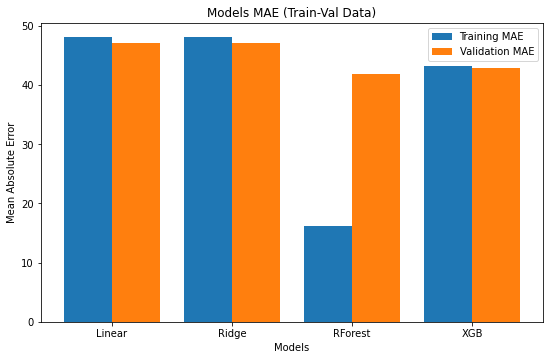

In [23]:
# Plot Models MAEs
w = 0.4
bar1 = np.arange(len(models_type))
bar2 = [i + w for i in bar1]


plt.figure(figsize=(9,5.5))
plt.bar(bar1, Training_MAEs, w, label='Training MAE')
plt.bar(bar2, Validation_MAEs, w, label='Validation MAE')

plt.xlabel('Models')
plt.ylabel('Mean Absolute Error')
plt.xticks(bar1+(w/2), models_type)
plt.legend()
plt.title('Models MAE (Train-Val Data)')

plt.show()

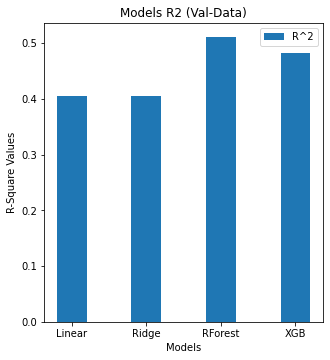

In [24]:
# Plot Models R^2s
w = 0.4
bar1 = np.arange(len(models_type))

plt.figure(figsize=(5,5.5))
plt.bar(bar1, models_R2s, w, label='R^2')

plt.xlabel('Models')
plt.ylabel('R-Square Values')
plt.xticks(bar1, models_type)
plt.legend()
plt.title('Models R2 (Val-Data)')

plt.show()

# **Tunning Random Forest Regressor**

In [25]:
param_grid = {"randomforestregressor__max_depth": range(18, 19),
              "randomforestregressor__n_estimators": range(115,116), 
              "randomforestregressor__max_samples":  [0.3],
             "randomforestregressor__min_samples_split": [4],
              "randomforestregressor__min_samples_leaf": [1],
              "randomforestregressor__bootstrap": [False],
              "randomforestregressor__max_features":['sqrt']
             }
model_rfr_search = GridSearchCV(
    model_rfr,
    param_grid = param_grid,
    cv=10,
    verbose=1# status updates
)

# Fit it to the data
model_rfr_search.fit(X, y);


Fitting 10 folds for each of 1 candidates, totalling 10 fits


In [26]:
model_rfr_search.best_params_

{'randomforestregressor__bootstrap': False,
 'randomforestregressor__max_depth': 18,
 'randomforestregressor__max_features': 'sqrt',
 'randomforestregressor__max_samples': 0.3,
 'randomforestregressor__min_samples_leaf': 1,
 'randomforestregressor__min_samples_split': 4,
 'randomforestregressor__n_estimators': 115}

In [27]:
check_metrics(model_rfr_search)

print('Test MAE:', mean_absolute_error(y_test, model_rfr_search.predict(X_test)))
print('Test R^2:', model_rfr_search.score(X_test,y_test))

Training MAE: 21.009996703097347
Validation MAE: 20.504351986729628
Validation R^2: 0.8795970017674922


Test MAE: 20.858750773796835
Test R^2: 0.8824555126219643


# **Tunning XGBRegressor**

In [28]:
param_grid = {"xgbregressor__booster": ['gbtree'],
              'xgbregressor__max_depth' :range(8,9),
              'xgbregressor__n_estimators':range(45,46),
              'xgbregressor__gamma':[0],
              'xgbregressor__scale_pos_weight':[5]
             }
model_xgb_search = RandomizedSearchCV(
    model_xgb,
    param_distributions = param_grid,
    cv=10,
    verbose=1# status updates
)

# Fit it to the data
model_xgb_search.fit(X, y);


Fitting 10 folds for each of 1 candidates, totalling 10 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:296: UserWarning:

The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.



In [29]:
check_metrics(model_xgb_search)

print('Test MAE:', mean_absolute_error(y_test, model_xgb_search.predict(X_test)))
print('Test R^2:', model_xgb_search.score(X_test,y_test))


Training MAE: 37.03275501714973
Validation MAE: 35.77199380890459
Validation R^2: 0.6451093609843077


Test MAE: 36.387234955456954
Test R^2: 0.6484620747328551


In [30]:
model_xgb_search.best_params_

{'xgbregressor__booster': 'gbtree',
 'xgbregressor__gamma': 0,
 'xgbregressor__max_depth': 8,
 'xgbregressor__n_estimators': 45,
 'xgbregressor__scale_pos_weight': 5}

# **Checking and Comparing Metrics (Tune Models)**

In [31]:
models = [model_rfr_search, model_xgb_search]
models_name = ['Tune RandomForestRegressor:','Tune XGBRegressor:']
for i in range(2):
  print(models_name[i])
  check_metrics(models[i])
print()
print('Tune RandomForestRegressor:')
print('Test MAE:', mean_absolute_error(y_test, model_rfr_search.predict(X_test)))
print('Test R^2:', model_rfr_search.score(X_test,y_test))
print()
print('Tune XGBRegressor:')
print('Test MAE:', mean_absolute_error(y_test, model_xgb_search.predict(X_test)))
print('Test R^2:', model_xgb_search.score(X_test,y_test))


Tune RandomForestRegressor:
Training MAE: 21.00999670309735
Validation MAE: 20.504351986729628
Validation R^2: 0.8795970017674921


Tune XGBRegressor:
Training MAE: 37.03275501714973
Validation MAE: 35.77199380890459
Validation R^2: 0.6451093609843077



Tune RandomForestRegressor:
Test MAE: 20.858750773796835
Test R^2: 0.8824555126219643

Tune XGBRegressor:
Test MAE: 36.387234955456954
Test R^2: 0.6484620747328551


# **Plot Tune Models**

In [32]:
# Lists to Plot Models
models = [model_rfr_search, model_xgb_search]
models_type = ['Tune RForest', 'Tune XGB']
Training_MAEs = []
Validation_MAEs = []
models_R2s = []

def listing_metrics(model):
  # Fill lists to plot and compare models
  Training_MAEs.append(mean_absolute_error(y_train, model.predict(X_train)))
  Validation_MAEs.append(mean_absolute_error(y_test, model.predict(X_test)))
  models_R2s.append(model.score(X_test, y_test))

for m in models:
  listing_metrics(m)

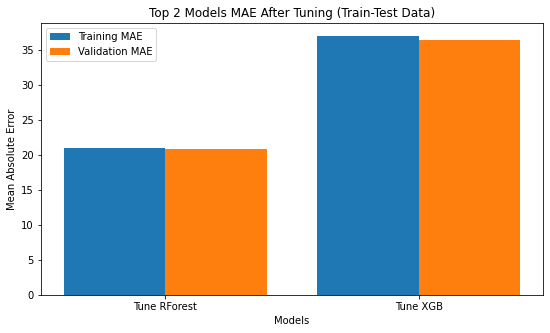

In [33]:
# Plot Models MAEs
w = 0.4
bar1 = np.arange(len(models_type))
bar2 = [i + w for i in bar1]


plt.figure(figsize=(9,5))
plt.bar(bar1, Training_MAEs, w, label='Training MAE')
plt.bar(bar2, Validation_MAEs, w, label='Validation MAE')

plt.xlabel('Models')
plt.ylabel('Mean Absolute Error')
plt.xticks(bar1+(w/2), models_type)
plt.legend()
plt.title('Top 2 Models MAE After Tuning (Train-Test Data)')

plt.show()

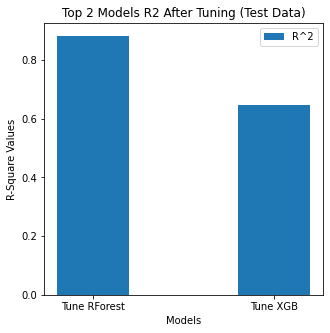

In [34]:
# Plot Models R^2s
w = 0.4
bar1 = np.arange(len(models_type))

plt.figure(figsize=(5,5))
plt.bar(bar1, models_R2s, w, label='R^2')

plt.xlabel('Models')
plt.ylabel('R-Square Values')
plt.xticks(bar1, models_type)
plt.legend()
plt.title('Top 2 Models R2 After Tuning (Test Data)')

plt.show()

# **Verifying Assumptions**

# No Multicolinearity

Text(0.5, 1.0, 'Features Correlation')

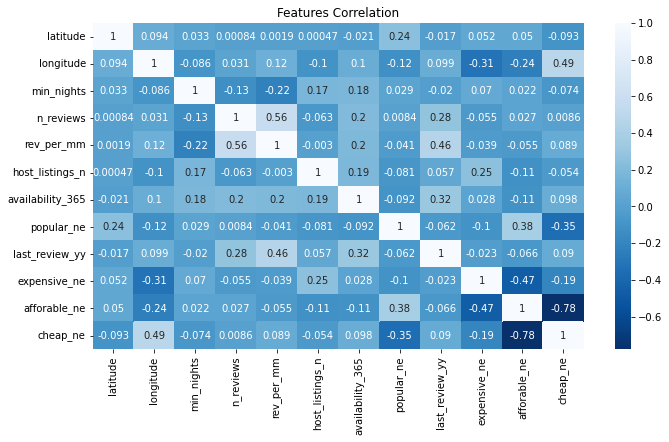

In [35]:
plt.figure(figsize=(11,6))
sns.heatmap(X_train.corr(), annot=True, cmap="Blues_r")
plt.title('Features Correlation')

# Normality of Residuals

In [36]:
residuals = y_test - (model_rfr_search.predict(X_test))

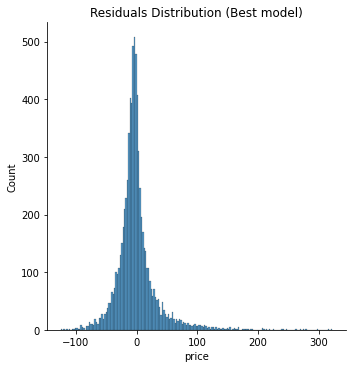

In [37]:
sns.displot(residuals)
plt.title('Residuals Distribution (Best model)');

# Homoscedasticity

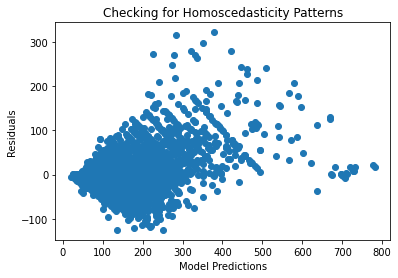

<Figure size 504x216 with 0 Axes>

In [38]:
y_pred = (model_rfr_search.predict(X_test))
plt.scatter(y_pred, residuals)
plt.xlabel('Model Predictions')
plt.ylabel('Residuals')
plt.title('Checking for Homoscedasticity Patterns')
plt.figure(figsize=(7,3));

# No Autocorrelation of Residuals

In [39]:
import statsmodels.api as sm
import statsmodels.tsa.api as smt

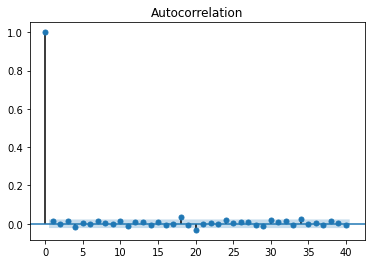

In [40]:
acf = smt.graphics.plot_acf(residuals, lags=40, alpha=0.05,)

acf.show();
